# Deep Learning &mdash; Assignment 6

Assignment for week 6 of the 2022 Deep Learning course (NWI-IMC070) of the Radboud University.

-----

**Names: Luka Mucko, Luca Poli**

**Group: 46**

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Build a graph neural network, using pytorch geometric
2. Compare a GNN with other network architectures
3. Compare different GNN layers and aggregation functions

## Required software

As before you will need these libraries:
* `torch`, `torch-sparse`, `torch-scatter`, and `torch-geometric` for PyTorch,
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book.

The recommended way to install these libraries is described in the [torch-geometric installation instructions](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html).

In [1]:
# Replace ${TORCH} and ${CUDA} with your torch and cuda versions.
# Or remove the -f argument to compile from source
#
#!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
#!pip install torch-geometric

In [2]:
%config InlineBackend.figure_formats = ['png']
%matplotlib inline

from d2l import torch as d2l
import itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch_geometric
from torch import nn
from torch.nn import Linear, Dropout
from torch.nn import functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, SAGEConv, GraphConv

/lustre/home/lmucko/.local/lib/python3.10/site-packages/torch_geometric/typing.py:47: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /lustre/home/lmucko/.local/lib/python3.10/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/lustre/home/lmucko/.local/lib/python3.10/site-packages/torch_geometric/typing.py:101: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /lustre/home/lmucko/.local/lib/python3.10/site-packages/torch_sparse/_metis_cuda.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


## 6.1 A node classification dataset (1 point)

In this assignment we will be working on a node classification problem using the Citeseer dataset. This is a graph dataset that contains bag-of-words representation of documents and citation links between the documents. So there is an edge between document $i$ and document $j$ if one cites the other. This is an undirected edge.

In [3]:
dataset = Planetoid(root='data', name='Citeseer', transform=NormalizeFeatures())

**(a) How many graphs are there in this dataset? How large are they (in terms of nodes and edges)?<span style="float:right"> (1 point)</span>**

In [4]:
# TODO: your answer here
print(f'Number of graphs: {len(dataset)}')
print(f"Number of nodes: {dataset[0].num_nodes}")
print(f"Number of edges: {dataset[0].num_edges}")

Number of graphs: 1
Number of nodes: 3327
Number of edges: 9104


In fact, we will continue the rest of this notebook using the first graph from the dataset.

In [5]:
data = dataset[0]  # Get the first graph object.

We will be use a subset of the nodes for training, and another subset for testing.
These subsets are indicated by `data.train_mask` and `data.test_mask` respectively.

## 6.2 MLP for node classification (6 points)

In theory, we should be able to classify documents based only on their content, that is, using the bag-of-words features, without taking the graph structure into account.

We can verify that by constructing a simple node-wise multilayer perceptron with a single hidden layer. This network does not use the edge information at all.

**(a) Complete the code below.<span style="float:right"> (2 points)</span>**

The network should have 2 linear layers. The hidden layer should have size `hidden_channels`, use ReLU activations, and use dropout with a dropout rate of 0.1. Don't use an activation function after the final layer.

Hint: avoid using `Sequential`, it will make the assignment harder later on.

In [6]:
class MLP(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels = 16):
        super().__init__()
        self.lin1 = torch.nn.Linear(num_features, hidden_channels)
        self.relu = torch.nn.ReLU()
        self.lin2 = torch.nn.Linear(hidden_channels, num_classes)
        self.dropout = torch.nn.Dropout(0.1)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.lin2(x)
        return x

**(b) Complete the training loop below.<span style="float:right"> (2 points)</span>**

Hint: compute the loss only on the training nodes.

Hint 2: `data.x` contains the features for each node, `data.y` contains their labels.

Hint 3: `model()` takes two parameters: a tensor of node features, and a tensor of edges. See the `test_accuracy` function.

In [7]:
device = d2l.cpu()

def accuracy(pred_y, true_y):
    correct = pred_y.argmax(dim=1) == true_y
    return int(correct.sum()) / len(true_y)

def test(model, data):
    loss_fn = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        model.eval()
        out = model(data.x, data.edge_index)
        # Compute loss and accuracy only on the 'test' nodes
        test_loss = loss_fn(out[data.test_mask], data.y[data.test_mask]).item()
        test_acc = accuracy(out[data.test_mask], data.y[data.test_mask])
        # Compute loss and accuracy only on the 'train' nodes
        train_loss = loss_fn(out[data.train_mask], data.y[data.train_mask]).item()
        train_acc = accuracy(out[data.train_mask], data.y[data.train_mask])
        return train_loss, train_acc, test_loss, test_acc

def train(model, data, lr=0.01, weight_decay=5e-4, epochs=400, plot=True, device="cuda"):
    model = model.to(device)
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = torch.nn.CrossEntropyLoss()
    if plot:
        animator = d2l.Animator(xlabel='epoch', xlim=[1, epochs], figsize=(10, 5),
                                legend=['train loss', 'train accuracy', 'test loss', 'test accuracy'])
    
    for epoch in range(1, epochs+1):
        model.train()
        # TODO: Compute and optimize loss
        out = model(data.x, data.edge_index)
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Compute test accuracy, and plot
        if plot and epoch % 10 == 0:
            train_loss, train_acc, test_loss, test_acc = test(model, data)
            animator.add(epoch + 1, (train_loss, train_acc, test_loss, test_acc))
    
    # Print final accuracy
    train_loss, train_acc, test_loss, test_acc = test(model, data)
    print(f'Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}')
    print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}')

**(c) Now construct and train an MLP on this dataset.<span style="float:right"> (1 point)</span>**

Train loss: 0.0834, Train accuracy: 1.0000
Test loss: 1.2217, Test accuracy: 0.6000


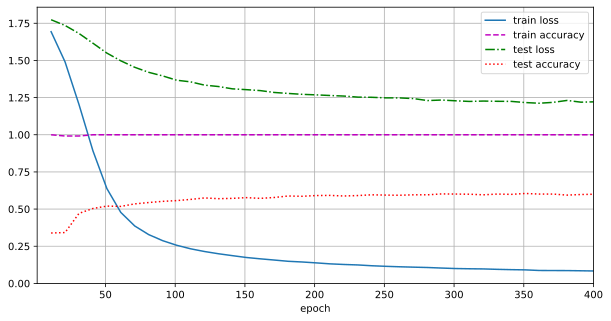

In [8]:
# TODO: construct and train the model
num_features = data.x.shape[1]
num_classes = len(torch.unique(data.y))
mlp_model = MLP(num_features, num_classes)
train(mlp_model, data, device='cuda')

**(d) The MLP network does not use the citation information at all. Give a way to incorporate the edge information without using a graph neural network?<span style="float:right"> (1 point)</span>**

Note that the method should still work for arbitrary citation graphs.

We can incorporate edge information by concatenating it with node features to create a combined feature vector for our model.
That way we don't need to use GNNs.




## 6.3 A graph convolutional neural network (3 points)

Next, we will use a graph neural network based on the Graph Convolutional Network approach, which was introduced in the paper [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/pdf/1609.02907.pdf).

**(a) Implement a graph convolutional neural network, by replacing the linear layers in the MLP with [`GCNConv` layers](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv), and train the network.<span style="float:right"> (1 point)</span>**

The network should have two `GCNConv` layers. The rest of the architecture should stay as close as possible to the MLP.

Train loss: 0.1413, Train accuracy: 1.0000
Test loss: 0.9310, Test accuracy: 0.7030


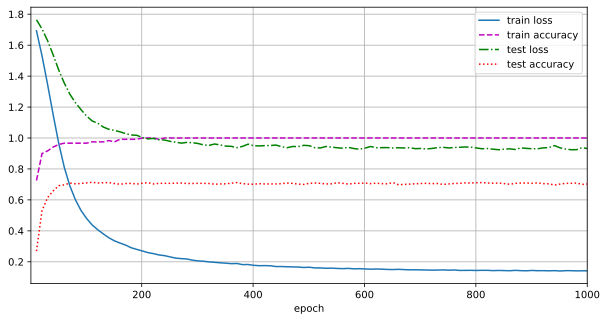

In [9]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels = 16):
        super().__init__()
        # TODO: initialize network layers
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.1)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # TODO: compute network output
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

# TODO: construct and train the model
gcn_model = GCN(num_features, num_classes)
train(gcn_model, data, device='cuda', epochs=1000)

**(b) Compare the results of the MLP and the GCN. Which model is better?<span style="float:right"> (1 point)</span>**

Comparing the results of the MLP and the GCN models, the GCN model is better. The test accuracy of the GCN model is higher compared to the MLP model. Thus, the GCN model outperforms the MLP model for this specific task.

**(c) Has the GCN training converged? Can you expect higher test accuracies by training longer? Explain your answer.<span style="float:right"> (1 point)</span>**

Yes, GCN training has converged. Running the training with 1000 epochs doesn't change the results in any noticeable way.

## 6.4 Comparing GNN layers (8 points)

Two graph layers that are interesting to compare are [`SAGEConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.SAGEConv) and [`GraphConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv). Aside from one of them supporting weighted graphs, these models differ only in the accumulation function.

**(a) Look at the documentation for these two layers. What is the difference in the accumulation function?<span style="float:right"> (1 point)</span>**

The GraphConv uses as aggregation function the sum of the features of the neighbors (can be changed to max or mean), while the SAGEConv uses a more complex aggregation function, where the default aggregator scheme is mean, but can be changed to any aggregator.

To avoid having to copy the GNN structure every time, we can make our code generic in the type of layer to use.

**(b) Make a generic graph neural network, that uses layers of type `layer_type`.<span style="float:right"> (1 point)</span>**

Hint: you can construct layers with `my_layer = layer_type(in_size, out_size, **layer_args)`.

In [10]:
class GNN(torch.nn.Module):
    def __init__(self, layer_type, num_features, num_classes, hidden_channels=16, **layer_args):
        super().__init__()
        # TODO: initialize network layers
        self.layer1 = layer_type(num_features, hidden_channels, **layer_args)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.1)
        self.layer2 = layer_type(hidden_channels, num_classes, **layer_args)

    def forward(self, x, edge_index):
        # TODO: same as before
        x = self.layer1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x, edge_index)
        return x

**(c) Train a SAGEConv network and a GraphConv network.<span style="float:right"> (no points)</span>**

Train loss: 0.0488, Train accuracy: 1.0000
Test loss: 0.9378, Test accuracy: 0.7010


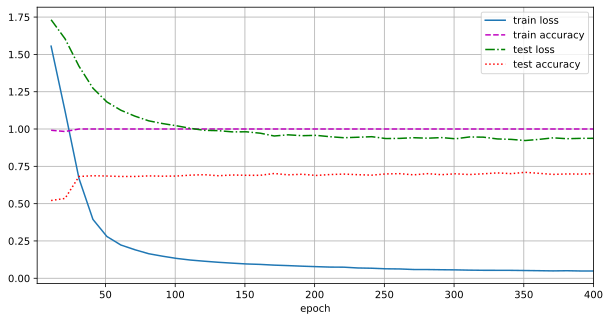

In [11]:
# TODO: construct and train a GNN with SAGEConv layers
sageconv_model = GNN(SAGEConv, num_features, num_classes)
train(sageconv_model, data)

Train loss: 0.0234, Train accuracy: 1.0000
Test loss: 1.3448, Test accuracy: 0.6350


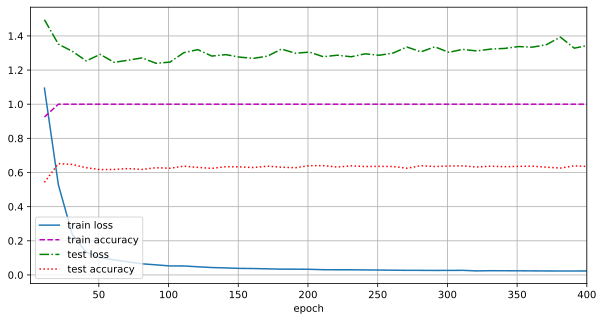

In [14]:
# TODO: construct and train a GNN with GraphConv layers
graphconv_model = GNN(GraphConv, num_features, num_classes)
train(graphconv_model, data)

**(d) Compare the performance of these two models, and also compare them to the GCN.<span style="float:right"> (1 point)</span>**

Hint: look at the test loss.

Between those two, the SAGEConv performs better, while the GraphConv overfit the train data.
But the performance of SAGEConv are similar to the GCN, without any significant difference.

**(e) Can you explain the observation in the previous question by looking at the aggregation functions? Why is one of them worse than the others?<span style="float:right"> (1 point)</span>**

The default aggregation function for the SAGEConv is the mean, while for the GraphConv is the sum which is more prone to overfitting due to the fact that the features are summed together, without any regularization.

In fact, it is possible to use different aggregation functions, by passing `aggr=` to the network constructor.

**(f) Compute the performance for `GraphConv` networks with `'mean'`, `'sum'`, `'min'`, `'max'`, and `'std'` aggregation.<span style="float:right"> (1 point)</span>**

Hint: train with `plot=False` to only show the final loss and accuracy.

Hint 2: if the performance is the same for all methods, there is most likely a bug in your `GNN` code.

In [13]:
for aggr in ['mean', 'sum', 'min', 'max', 'std']:
    train(GNN(GraphConv, num_features, num_classes, aggr=aggr), data, plot=False)

Train loss: 0.0528, Train accuracy: 1.0000
Test loss: 0.9270, Test accuracy: 0.7020
Train loss: 0.0223, Train accuracy: 1.0000
Test loss: 1.3309, Test accuracy: 0.6290
Train loss: 0.0507, Train accuracy: 1.0000
Test loss: 1.0200, Test accuracy: 0.6850
Train loss: 0.0337, Train accuracy: 1.0000
Test loss: 1.0342, Test accuracy: 0.6650
Train loss: 0.0711, Train accuracy: 1.0000
Test loss: 1.1794, Test accuracy: 0.6230


**(g) Which three aggregation methods are the worst? For each one, explain why that one would not work well.<span style="float:right"> (3 points)</span>**

Hint: bag-of-word features are very sparse.

The three worst methods are sum, max and std.
The sum is not suitable for sparse data as it may not effectively capture the importance of single feature (due to the prevalence of 0) and doesn't have any regularization.
The max may discard relevant information in sparse data as it focuses on the highest feature values
The std is too sensitive to outliers and may not be suitable for sparse data (due to the prevalence of 0).

## 6.5 Discussion (3 points)

**(a) Our training procedure gets the entire graph, including test nodes. Is it possible for the model to cheat using leaked information?<span style="float:right"> (1 point)</span>**

Yes, because the network computes the neighbours of the nodes and those neighbours might be in the test or validation sets.

**(b) Can the GCN and GNN networks use information from neighbors of neighbors to classify a node? Briefly explain your answer.<span style="float:right"> (1 point)</span>**

Both GCN and GNN networks can use information from neighbors of neighbors to classify a node. They aggregate information from a node's entire neighborhood, including not only its immediate neighbors but also their neighbors in the graph.


**(c) Do you think the trained model will generalize to other graphs? Motivate your answer.<span style="float:right"> (1 point)</span>**

The trained model may not generalize well to other graphs. Its performance on new graphs depends on how similar they are to the training graph in terms of the task and data distribution. Graph characteristics vary, and the model may need adaptation or fine-tuning for each new graph. Generalization depends on alignment with the training graph.




## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 21 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version f502e67 / 2023-10-04</span>